In [4]:
library(tbm)
library(tram)

In [5]:
data_import = function(dataname){
  filename  = paste('https://raw.githubusercontent.com/avinashbarnwal/GSOC-2019/master/AFT/test/data/neuroblastoma-data-master/data/',dataname,'/',sep="")
  inputFileName = paste(filename,'inputs.csv',sep="")
  labelFileName = paste(filename,'outputs.csv',sep="")
  foldsFileName = paste(filename,'cv/equal_labels/folds.csv',sep="")
  inputs        = read.table(inputFileName,sep=",",header=T,stringsAsFactors = F,row.names=1)
  labels        = read.table(labelFileName,sep=",",header=T,stringsAsFactors = F,row.names=1)
  folds         = read.table(foldsFileName,sep=",",header=T,stringsAsFactors = F,row.names=1)
  res           = list()
  res$inputs    = inputs
  res$labels    = labels
  res$folds     = folds
  return(res)
}

In [6]:
data_massage = function(inputs,labels){
    rownamesInput = rownames(inputs)
    inputs        = do.call(data.frame,lapply(inputs, function(x) replace(x, is.infinite(x),NA)))
    naColumns     = colnames(inputs)[colSums(is.na(inputs))>0]
    noVarCol      = getNonVarCols(inputs)
    removeCols    = c(naColumns,noVarCol)
    inputs        = inputs[ , !(colnames(inputs) %in% removeCols)]
    rownames(inputs) = rownamesInput
    labels$min.log.lambda = unlist(lapply(labels$min.log.lambda,exp))
    labels$max.log.lambda = unlist(lapply(labels$max.log.lambda,exp))
    res        = list()
    res$inputs = inputs
    res$labels = labels
    return(res)
}

In [7]:
getXY<-function(foldNo,folds,inputs,labels){
    test.id       = rownames(subset(folds,fold==foldNo))
    train.id      = rownames(subset(folds,fold!=foldNo))
    X             = subset(inputs,rownames(inputs) %in% train.id)
    X             = as.matrix(X)
    X.val         = subset(inputs,rownames(inputs) %in% test.id)
    X.val         = as.matrix(X.val)
    y.label       = subset(labels,rownames(labels) %in% train.id)
    y.label.test  = subset(labels,rownames(labels) %in% test.id)
    y.lower       = as.matrix(y.label$min.log.lambda)
    y.upper       = as.matrix(y.label$max.log.lambda)
    y.lower.val   = as.matrix(y.label.test$min.log.lambda)
    y.upper.val   = as.matrix(y.label.test$max.log.lambda)
    res           = list()
    res$X         = X
    res$X.val     = X.val
    res$y.lower      = y.lower
    res$y.lower.val  = y.lower.val
    res$y.upper      = y.upper
    res$y.upper.val  = y.upper.val
    return(res)
}

In [8]:
getNonVarCols<-function(data){
    var_columns    = apply(inputs,2,var)
    resCol         = names(var_columns[var_columns==0.0])
    return(resCol)
}

In [9]:
# Set Parameters
dataNameRange       = c('ATAC_JV_adipose','CTCF_TDH_ENCODE','H3K27ac-H3K4me3_TDHAM_BP','H3K27ac_TDH_some','H3K36me3_AM_immune')
sigma_range         = c(1,2,5,10,100)
distribution_range  = c('normal','logistic','extreme')
learning_rate       = 0.1
num_round           = 200

In [10]:
res                 = data_import(dataNameRange[1])
inputs              = res$inputs
labels              = res$labels
folds               = res$folds
resDataMassage      = data_massage(inputs,labels)
inputs              = resDataMassage$inputs
labels              = resDataMassage$labels
fold_iter           = unique(folds$fold)
accuracy_fold       = numeric(length(fold_iter))
coef_model          = list()

In [11]:
getaccuracy=function(pred,y_lower,y_higher){
    res = (pred>=y_lower & pred<=y_higher)
    return(res)
}

In [13]:
i = 1
res                 = getXY(fold_iter[i],folds,inputs,labels)
X                   = res$X
X.val               = res$X.val
y.lower             = res$y.lower
y.lower.val         = res$y.lower.val
y.upper             = res$y.upper
y.upper.val         = res$y.upper.val
train.folds         = cut(seq(1,nrow(X)),breaks=5,labels=FALSE)
res                 = list()
my.surv             = Surv(y.lower,y.upper,type='interval2')
formula             = as.formula(paste("my.surv ~", paste(colnames(X),collapse="+")))
trn.data            = data.frame(X,y.lower,y.upper)
tst.data            = data.frame(X.val)

In [16]:
### With STM - Mboost/Mboost (Additive Smooth Models)
trn.data$y.lower = trn.data$y.upper = NULL

In [15]:
trn.data$my.surv = my.surv
m_mlt = Survreg(my.surv~1, data = trn.data, dist = "lognormal")

[   1] ...................................... -- risk: 457.6516 
[  41] ...................................... -- risk: 455.8226 
[  81] ...................................... -- risk: 454.0898 
[ 121] ...................................... -- risk: 452.4478 
[ 161] ......................................
Final risk: 450.8916 


Warning message in c.basis(bresponse = response, bshifting = shifting):
“more than one basis contains an intercept term”


'log Lik.' -459.4352 (df=2)

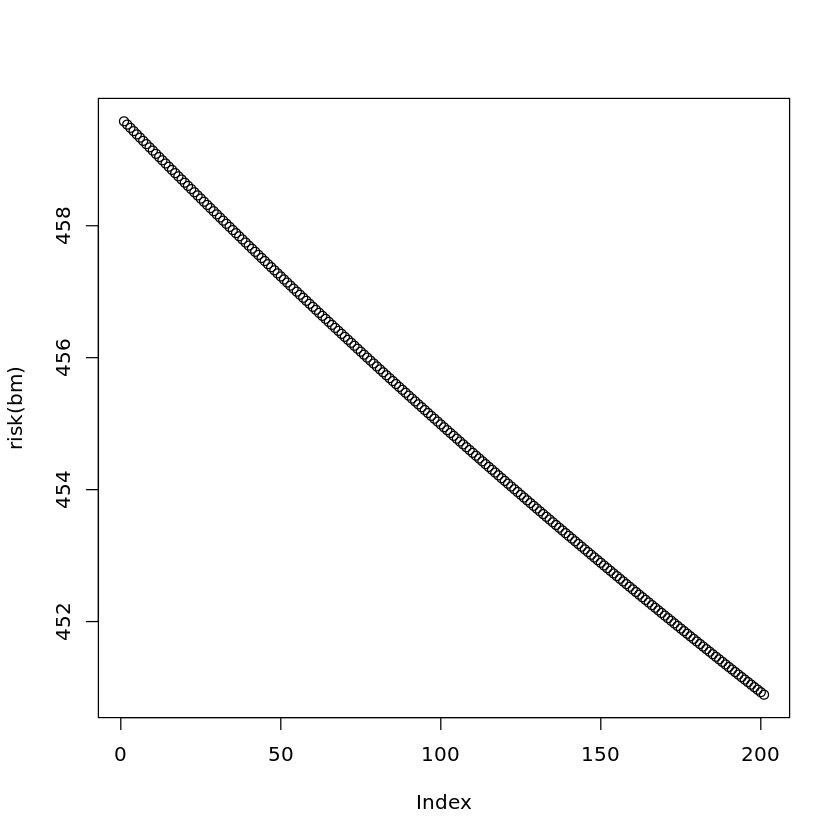

In [17]:
bm = stmboost(m_mlt, formula = formula, data = trn.data,control = boost_control(mstop=200,nu=0.001,trace=TRUE),method = quote(mboost::mboost))
### look at in-sample performance
logLik(m_mlt)
plot(risk(bm)) ### this is the negative log-lik

[   1] ...................................... -- risk: 407.416 
[  41] ...................................... -- risk: 406.2208 
[  81] ...................................... -- risk: 405.0974 
[ 121] ...................................... -- risk: 404.0444 
[ 161] ...................................... -- risk: 403.0574 
[ 201] ...................................... -- risk: 402.2382 
[ 241] ...................................... -- risk: 401.5108 
[ 281] ...................................... -- risk: 400.8032 
[ 321] ...................................... -- risk: 399.0674 
[ 361] ...................................... -- risk: 398.8001 
[ 401] ...................................... -- risk: 398.5091 
[ 441] ...................................... -- risk: 397.5129 
[ 481] ..................
Final risk: 397.0242 


Warning message in c.basis(bresponse = response, bshifting = shifting):
“more than one basis contains an intercept term”


'log Lik.' -409.3729 (df=29)

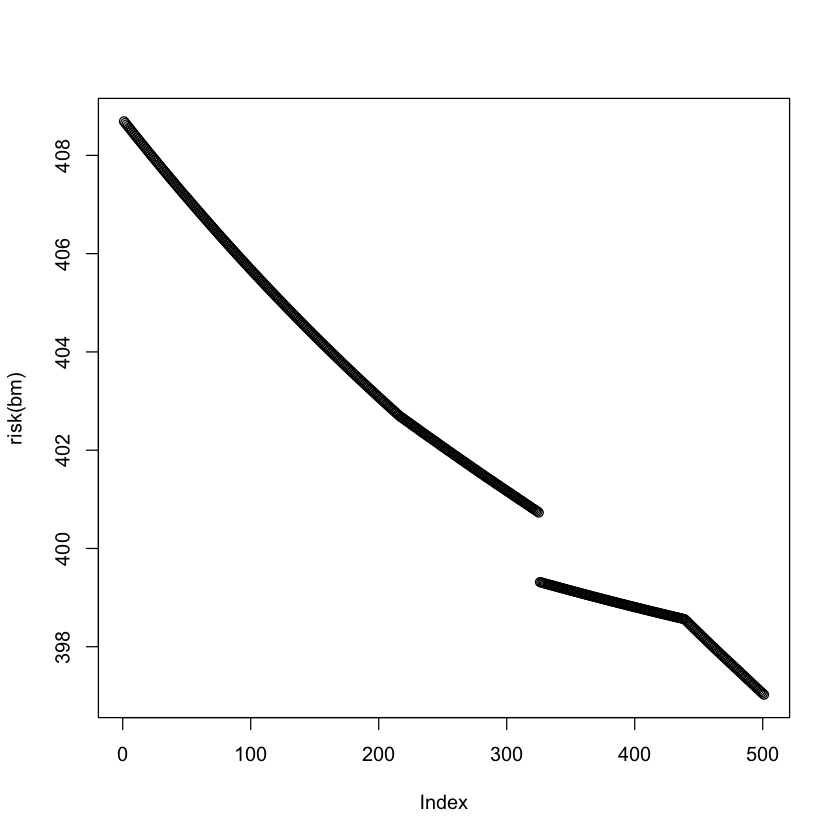

In [11]:
### With STM - Mboost/BlackBoost (Additive Smooth Models)
trn.data$y.lower = trn.data$y.upper = NULL
trn.data$my.surv = my.surv
m_mlt            = Survreg(formula, data = trn.data, dist = "lognormal")
bm               = stmboost(m_mlt, formula = formula, control = boost_control(mstop=500,nu=0.001,trace=TRUE),data = trn.data,method = quote(mboost::blackboost))
### look at in-sample performance
### this is the negative log-lik
logLik(m_mlt)
plot(risk(bm))

In [18]:
pred.mat <- predict(bm,newdata = trn.data,type = "density",q = 0.5)

In [19]:
pred.mat

7.782131e-16,2.794907e-15,4.400282e-15,5.166047e-15,3.254843e-15,2.885559e-15,7.782131e-16,2.794907e-15,4.400282e-15,5.166047e-15,⋯,2.794907e-15,4.400282e-15,5.166047e-15,5.53266e-15,3.107275e-15,3.254843e-15,3.519876e-15,4.688572e-15,3.609756e-15,2.885559e-15


In [26]:
### set-up some quantiles
q = seq(from = 0, to = max(trn.data$my.surv[,1]), length.out = 100)

In [27]:
### compute conditional density
d = predict(bm, newdata = trn.data[1:10,], type = "density", q = q)
### NOTE: obs are in columns, not rows!

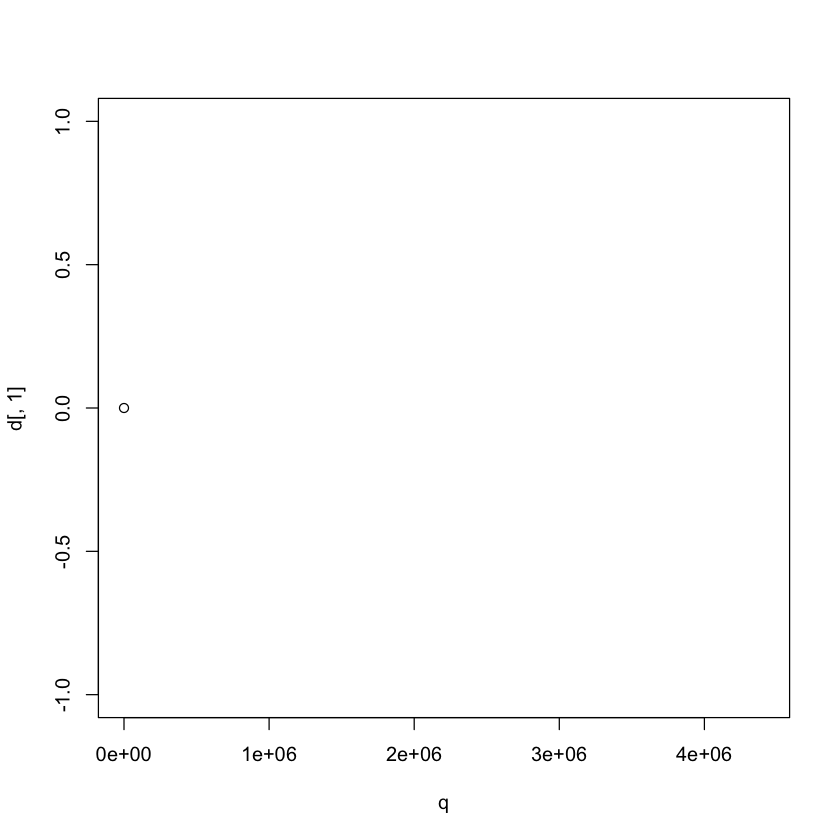

In [28]:
### plot density of first subject
plot(q, d[,1])